In [1]:
%load_ext tensorboard

In [2]:
import os
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from assets.ml.DeepONetwork import TrunkNN
from assets.ml.DeepONetwork import BranchNN
from assets.ml.DeepONetwork import DeepONET
from assets.ml.DeepONetwork import DeepOPINN

2023-12-01 22:15:35.931440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
log_dir = os.path.join(".", "assets", "logs", f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh') for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh') for i in range(5)]


branchNET = BranchNN()
trunkNET = TrunkNN()
deepONET = DeepONET(branchNN=branchNET, trunkNN=trunkNET)

In [33]:
domain = np.linspace(0, 1, 100)

In [39]:
def f(x):
    return np.sin(2*np.pi*x)

def g(x):
    return np.cos(2*np.pi*x)

In [40]:
u = f(domain)
v = g(domain)

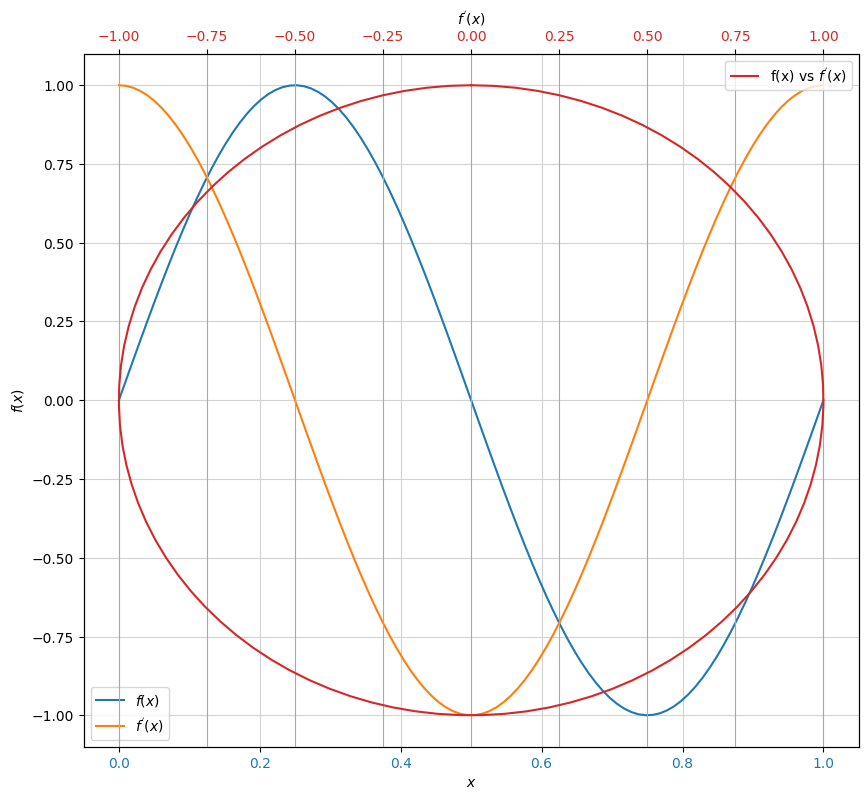

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(domain, u, label = "$f(x)$")
ax.plot(domain, v, label = "$f^{'}(x)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.grid(True, color='lightgrey')
ax.legend()

ax2 = ax.twiny()
ax2.plot(u, v, color="C3", label = "f(x) vs $f^{'}(x)$")
ax2.set_xlabel("$f^{'}(x)$")
ax2.set_ylabel("$f(x)$")
ax2.grid(True, color='darkgrey')
ax2.tick_params(axis='x', labelcolor = 'tab:red')
ax2.legend()

plt.show()